##**Import Library**

In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from typing import Tuple
import copy as cp

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**Load Dataset**

In [ ]:
# Mengakses dataset
df = pd.read_excel('/content/gdrive/MyDrive/Riset/data-label.xlsx')
df.head()

,Nama,Waktu,Rating,Review,Label
0,dwi merak,2 bulan lalu,"5,0",Pantainya bagus dan lumayan bersih. Hanya saya...,P
1,abang D,4 bulan lalu,"3,0",Tempatnya sejuk dibawah pohon laut yg di hembu...,P
2,Tsurayya Kamila Novita,2 bulan lalu,"5,0",Pantai yang sungguh cantik dengan pengelolaan ...,P
3,Yuliyanti Zane,sebulan lalu,"5,0","Air pantainya terlihat biru, indah bgt.. kesan...",P
4,Azizah Fajar Budiani,sebulan lalu,"5,0","Pantai Bersih, Pasir Putih, Laut Biru, Pengina...",P


In [ ]:
df['Label'].value_counts()

P     1654
N      180
NT     146
Name: Label, dtype: int64

In [ ]:
# Mengecek data kosong
df.isnull().sum()

Nama      0
Waktu     0
Rating    0
Review    0
Label     0
dtype: int64

In [ ]:
# Melihat dimensi data
df.shape

(1980, 5)

In [ ]:
df['Review'].iloc[1]

'Tempatnya sejuk dibawah pohon laut yg di hembus angin semilir pantai sebagai ac alami dari Allah. Hamparan Pemandangan laut yg luas dgn pulau2. Mushalla t4 ibadah ada dgn air tawar yg bersih. Kedai2 makanan kecil banyak bahkan makanan berat sekalipun ada, nasi, bakso, mieso, soto dll. Disini ada juga pondok2 t4 nginapnya gaes.\nWaktu kunjungan\nAkhir pekan\n\nWaktu antrean\nTanpa mengantre\n\nSebaiknya buat reservasi\nTidak'

In [ ]:
df_copy = df.copy()

##**Preprocessing Data**

###**Cleaning Data**

In [ ]:
def clean(text):
  # Menghapus newline
  text = text.replace('\n', ' ')

  # Menghapus non-ascii
  text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')

  # Menghapus tanda baca
  text = re.sub('\w+:\/\/\S+', '', text)
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('[^a-zA-Z]', ' ', text)

  # Menghapus white space
  text = re.sub('[\s]+', ' ', text)

  return text

In [ ]:
df['Review'] = df['Review'].apply(clean)
df['Review'].head()

0    Pantainya bagus dan lumayan bersih Hanya sayan...
1    Tempatnya sejuk dibawah pohon laut yg di hembu...
2    Pantai yang sungguh cantik dengan pengelolaan ...
3    Air pantainya terlihat biru indah bgt kesana p...
4    Pantai Bersih Pasir Putih Laut Biru Penginapan...
Name: Review, dtype: object

###**Case Folding**

In [ ]:
def case_folding(text):
  text = text.lower()
  return text

df['Review'] = df['Review'].apply(case_folding)
df['Review'].head()

0    pantainya bagus dan lumayan bersih hanya sayan...
1    tempatnya sejuk dibawah pohon laut yg di hembu...
2    pantai yang sungguh cantik dengan pengelolaan ...
3    air pantainya terlihat biru indah bgt kesana p...
4    pantai bersih pasir putih laut biru penginapan...
Name: Review, dtype: object

###**Tokenizing**

In [ ]:
nltk.download('punkt')
def tokenizer(text):
  return word_tokenize(text)

df['Review'] = df['Review'].apply(tokenizer)
df['Review'].head(20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     [pantainya, bagus, dan, lumayan, bersih, hanya...
1     [tempatnya, sejuk, dibawah, pohon, laut, yg, d...
2     [pantai, yang, sungguh, cantik, dengan, pengel...
3     [air, pantainya, terlihat, biru, indah, bgt, k...
4     [pantai, bersih, pasir, putih, laut, biru, pen...
5     [pantai, dengan, ombak, yang, tenang, dan, cuk...
6     [keren, sih, tempatnya, buat, liburan, keluarg...
7     [view, sangat, cantik, tapi, fasilitas, belum,...
8     [pantainya, keren, bersih, cottage, nya, juga,...
9     [tempat, wisata, pantai, yg, rekomended, view,...
10                                            [menarik]
11                                  [bagus, dan, alami]
12                                 [recomended, banget]
13                                     [lumayan, bagus]
14                            [lebih, tingkatkan, lagi]
15                                      [bagus, sekali]
16                                            [eksotik]
17                                    [bagus, n,

###**Stopword**

In [ ]:
nltk.download('stopwords')
list_stopword = stopwords.words('indonesian')

# Menambahkan kata yang perlu dihapus
list_stopword.extend(['yg', 'n', 'nan', 'and', 'dn','ter', 'dgn', 'lho', 'ter',
                      'per', 't', 'gaes', 'D', 'd','gan', 'for', 'dll', 'pd', 'g',
                      'deh', 'sd', 'cuy', 'nya', 'sih', 'nih','lan','bal', 'gc',
                      'bngat', 'bngt', 'brow', 'sihni', 'bray', 'ya', 'i', 'bo',
                      'ft', 'rb', 'jd', 'tp', 'utk', 'lg', 'lh', 'x', 'nd', 'bwt',
                      'tpi', 'cb', 'cuk', 'njim', 'iam', 'mah', 'y', 'xg', 'lgi',
                      'mw', 'gan', 'krna', 'untk', 'dsb','dah', 'si', 'gw', 'in',
                      'poolll', 'sbg', 'rem', 'yah', 'k', 'bgt', 'bs', 'dg','kl',
                      'jg', 'tuk', 'tpie', 'ama', 'msh', 'tidak bagus', 'tidak bagus',
                      'tidak bersih', 'kurang banyak', 'tapi sayang', 'tidak senang', 'tidak cocok'])

list_stopword = set(list_stopword)

def stopword(words):
  return [word for word in words if word not in list_stopword]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Daftar kata pada corpus nltk dan tambahan
list_stopword

{'D',
 'ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'ama',
 'amat',
 'amatlah',
 'and',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'bal',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 

In [ ]:
df['Review'] = df['Review'].apply(stopword)
df['Review'].head()

0    [pantainya, bagus, lumayan, bersih, sayangnya,...
1    [tempatnya, sejuk, dibawah, pohon, laut, hembu...
2    [pantai, sungguh, cantik, pengelolaan, fasilit...
3    [air, pantainya, biru, indah, kesana, pas, wee...
4    [pantai, bersih, pasir, putih, laut, biru, pen...
Name: Review, dtype: object

In [ ]:
df['Review'].to_csv('datastopword1.csv')

###**Konversi Slangword**

In [ ]:
# mengakses dataset kamus
slang_dictionary = pd.read_csv('/content/gdrive/MyDrive/Riset/kamus_slangword.txt',
                               sep=';',
                               header=None,
                               names=['slang', 'formal'])
slang_dictionary.head()

,slang,formal
0,dgn,dengan
1,banget,sekali
2,rb,ribu
3,t4,tempat
4,bgt,banget


In [ ]:
# Mengkonversi menjadi dictionary
slang_dict = pd.Series(slang_dictionary['formal'].values,
                       index=slang_dictionary['slang']).to_dict()

In [ ]:
# Membuat fungsi slangwords
def Slangwords(text):
    for word in text:
      if word in slang_dict.keys():
        text = list(map(lambda x: x.replace(word, slang_dict[word]), text))
    return text

# Terapkan fungsi diatas
df['Review'] = df['Review'].apply(Slangwords)
df['Review'].head()

0    [pantainya, bagus, dan, lumayan, bersih, hanya...
1    [tempatnya, sejuk, dibawah, pohon, laut, yang,...
2    [pantai, yang, sungguh, cantik, dengan, pengel...
3    [air, pantainya, terlihat, biru, indah, bangae...
4    [pantai, bersih, pasir, putih, laut, biru, pen...
Name: Review, dtype: object

In [ ]:
df['Review'].to_csv('dataslangword1.csv')

###**Stemming**

In [ ]:
# Membuat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(term):
  return stemmer.stem(term)

term_dict = {}

for doc in df['Review']:
  for term in doc:
    if term not in term_dict:
      term_dict[term] = ' '

print(len(term_dict))
print('------------------------------')

for term in term_dict:
  term_dict[term] = stemming(term)
  print(term, ':', term_dict[term])

2989
------------------------------
pantainya : pantai
bagus : bagus
dan : dan
lumayan : lumayan
bersih : bersih
hanya : hanya
tetapi : tetapi
kurang : kurang
luas : luas
tiket : tiket
masuk : masuk
ribu : ribu
tersedia : sedia
tempat : tempat
menginap : inap
kamar : kamar
mandi : mandi
luar : luar
dalam : dalam
untuk : untuk
mencapai : capai
pulau : pulau
gili : gili
genting : genting
ini : ini
dengan : dengan
menggunakan : guna
perahu : perahu
tarif : tarif
per : per
orang : orang
maupun : maupun
sepeda : sepeda
motor : motor
upah : upah
menaikan : naik
menurunkan : turun
di : di
pelabuhan : labuh
tanjung : tanjung
sebesar : besar
tempatnya : tempat
sejuk : sejuk
dibawah : bawah
pohon : pohon
laut : laut
yang : yang
hembus : hembus
angin : angin
semilir : milir
pantai : pantai
sebagai : bagai
ac : ac
alami : alami
dari : dari
allah : allah
hamparan : hampar
pemandangan : pandang
mushalla : mushalla
t : t
ibadah : ibadah
ada : ada
air : air
tawar : tawar
kedai : kedai
makanan : makan


In [ ]:
# Stemming ke dataframe
def get_stemm(doc):
  return [term_dict[term] for term in doc]

df['Review'] = df['Review'].apply(get_stemm)
df['Review'].head()

0    [pantai, bagus, dan, lumayan, bersih, hanya, t...
1    [tempat, sejuk, bawah, pohon, laut, yang, di, ...
2    [pantai, yang, sungguh, cantik, dengan, kelola...
3    [air, pantai, lihat, biru, indah, bangaet, kes...
4    [pantai, bersih, pasir, putih, laut, biru, ina...
Name: Review, dtype: object

###**Feature Selection**

In [ ]:
# Menghapus kolom yang tidak digunakan
df_clean = df.drop(columns=['Nama', 'Waktu', 'Rating'])
df_clean.head()

,Review,Label
0,"[pantai, bagus, lumayan, bersih, tetapi, luas,...",P
1,"[tempat, sejuk, bawah, pohon, laut, hembus, an...",P
2,"[pantai, sungguh, cantik, kelola, fasilitas, l...",P
3,"[air, pantai, biru, indah, kesana, pas, weekda...",P
4,"[pantai, bersih, pasir, putih, laut, biru, ina...",P


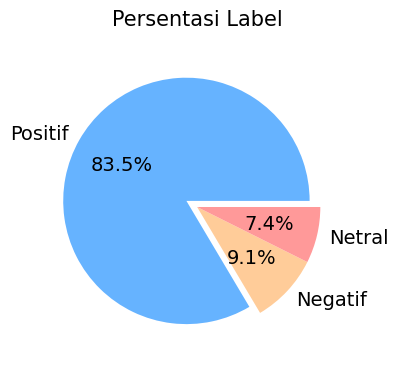

In [ ]:
# Visualisasi persentase label
fig, ax = plt.subplots(figsize = (4, 4))
sizes = [count for count in df_clean['Label'].value_counts()]
labels = ["Positif", "Negatif", "Netral"]
explode = (0.1, 0, 0)
colors = ['#66b3ff', '#ffcc99', '#ff9999']
ax.pie(x=sizes,
       labels=labels,
       colors=colors,
       autopct='%1.1f%%',
       explode=explode,
       textprops={'fontsize': 14})
ax.set_title('Persentasi Label', fontsize = 15, pad = 20)
plt.show()

###**Encoding Data Target**

In [ ]:
# Melakukan encoding terhadap label
df_clean['Label'] = df_clean['Label'].astype('category')
df_clean['Label'] = df_clean['Label'].cat.codes
df_clean.head()

,Review,Label
0,"[pantai, bagus, lumayan, bersih, tetapi, luas,...",2
1,"[tempat, sejuk, bawah, pohon, laut, hembus, an...",2
2,"[pantai, sungguh, cantik, kelola, fasilitas, l...",2
3,"[air, pantai, biru, indah, kesana, pas, weekda...",2
4,"[pantai, bersih, pasir, putih, laut, biru, ina...",2


In [ ]:
df_clean['Label'].unique()

array([2, 0, 1], dtype=int8)



*   0 = Negative
*   1 = Neutral
*   2 = Positive



###**TF-IDF**

In [ ]:
# konversi list ke string
def convert_text(texts):
  return ' '.join([text for text in texts])

df_clean['review'] = df_clean['Review'].apply(convert_text)
df_clean['review'].head()

0    pantai bagus lumayan bersih tetapi luas tiket ...
1    tempat sejuk bawah pohon laut hembus angin mil...
2    pantai sungguh cantik kelola fasilitas lengkap...
3    air pantai biru indah kesana pas weekday sepi ...
4    pantai bersih pasir putih laut biru inap jajan...
Name: review, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
response = vectorizer.fit_transform(df_clean['review'])
print(response)

  (0, 1592)	0.15809488024325685
  (0, 826)	0.13902574492899158
  (0, 1699)	0.19256531505599775
  (0, 1052)	0.22852376955172307
  (0, 1726)	0.24524349873817586
  (0, 1018)	0.3161897604865137
  (0, 1448)	0.43502153095768453
  (0, 1136)	0.12589654860393407
  (0, 1595)	0.175845585869545
  (0, 1205)	0.1314680223026915
  (0, 464)	0.14077180133078798
  (0, 473)	0.13080002369259985
  (0, 1276)	0.11698239136903976
  (0, 277)	0.21751076547884227
  (0, 924)	0.3161897604865137
  (0, 683)	0.3050203425703924
  (0, 578)	0.10451579209658643
  (0, 1416)	0.12533221055811541
  (0, 950)	0.13656978357926225
  (0, 1643)	0.14457093586738795
  (0, 896)	0.175845585869545
  (0, 1634)	0.175845585869545
  (0, 190)	0.07947175486483654
  (0, 898)	0.1373681352509999
  (0, 107)	0.07425936136483996
  :	:
  (1979, 1290)	0.08793064388141898
  (1979, 1412)	0.25576685880062217
  (1979, 620)	0.07939556065695219
  (1979, 1378)	0.09104422055184407
  (1979, 1282)	0.06751082922315826
  (1979, 1180)	0.06414415278762614
  (1979,

**Membuat dataframe agar lebih mudah melihat setiap token pada data**.
<br/>
Note: Dataframe dibawah ini tidak ada hubungan/pengaruh terhadap model atau code lain.

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Bobot keseluruhan data
df_tfidf = pd.DataFrame(response.todense().T,
                        index=vectorizer.get_feature_names_out(),
                        columns=[f'D{i+1}' for i in range(len(df_clean['review']))])

In [ ]:
df_tfidf.head()

D1        D2   D3   D4   D5   D6   D7   D8   D9  D10  D11  D12  D13  \
abai    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abis    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abiz    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abrasi  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ac      0.0  0.141178  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        D14  D15  D16  D17  D18  D19  D20  D21  D22  D23  D24  D25  D26  D27  \
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abis    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abiz    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abrasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ac      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        D28  D29  D30  D31  D32  D33  D34  D35  D36  D37  D38  D39  D40  D41  \
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abis    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abiz    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abrasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ac      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        D42  D43  D44  D45  D46  D47  D48  D49  D50  D51  D52       D53  D54  \
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
abis    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
abiz    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
abrasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
ac      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.637041  0.0   

        D55  D56  D57  D58  D59  D60  D61  D62  D63  D64  D65  D66  D67  D68  \
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abis    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abiz    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abrasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ac      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        D69  D70  D71  D72  D73  D74  D75  D76  D77  D78  D79  D80  D81  D82  \
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abis    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abiz    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
abrasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ac      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        D83  D84  D85  D86  D87  D88  D89  D90  D91  D92  D93      D94  D95  \
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00000  0.0   
abis    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.54075  0.0   
abiz    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00000  0.0   
abrasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00000  0.0   
ac      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00000  0.0   

        D96  D97  D98  D99  D100  D101  D102  D103  D104  D105  D106  D107  \
abai    0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
abis    0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
abiz    0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
abrasi  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ac      0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

        D108  D109  D110  D111  D112  D113  D114  D115  D116  D117  D118  \
abai     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
abis     0.0   0.0   0.0   

In [ ]:
# Bobot data baris pertama atau index ke 0
df_tfidf1 = pd.DataFrame(response[0].todense().T,
                        index=vectorizer.get_feature_names_out(),
                        columns=['tfidf'])
df_tfidf1.sort_values(by=['tfidf'], ascending=False).head(25)

,tfidf
sepeda,0.435022
motor,0.316190
mandi,0.316190
kamar,0.305020
upah,0.245243
naik,0.228524
capai,0.217511
turun,0.192565
tarif,0.175846
tetapi,0.175846


###**Menentukan Variabel**

In [ ]:
# Menentukan variabel independen dan variabel target
X = response
y = df_clean['Label']
print(X.shape,y.shape)

(1980, 1787) (1980,)


In [ ]:
df_clean['Label'].unique()

array([2, 0, 1], dtype=int8)

##**Modeling**

**Membuat Fungsi Classification Report**

In [ ]:
def classification_report_with_accuracy_score(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

**Membuat Fungsi Confusion Matrix**

In [ ]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    no_classes = len(np.unique(y))
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes])

    for train_ndx, test_ndx in kfold.split(X):
        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
        actual_classes = np.append(actual_classes, test_y)
        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))
        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)
    return actual_classes, predicted_classes, predicted_proba

In [ ]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(matrix,
                annot=True,
                xticklabels=sorted_labels,
                yticklabels=sorted_labels,
                cmap="Blues",
                fmt="g")
    plt.xlabel('Predicted');
    plt.ylabel('Actual');
    plt.title('Confusion Matrix')
    plt.show()

###**Pengujian Jumlah Tree**

####**Jumlah Tree = 100**

In [ ]:
model_tree_100 = RandomForestClassifier(n_estimators=100,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_tree_100 = cross_val_score(model_tree_100, X, y, cv=cv,
                                  scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_tree_100)
print('Rata-rata akurasi :', scores_tree_100.mean())

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.47      0.64        15
           2       0.92      1.00      0.96       167

    accuracy                           0.93       198
   macro avg       0.97      0.70      0.79       198
weighted avg       0.93      0.93      0.92       198

              precision    recall  f1-score   support

           0       1.00      0.56      0.72        16
           1       1.00      0.18      0.30        17
           2       0.89      1.00      0.94       165

    accuracy                           0.89       198
   macro avg       0.96      0.58      0.65       198
weighted avg       0.91      0.89      0.87       198

              precision    recall  f1-score   support

           0       0.88      0.74      0.80        19
           1       1.00      0.22      0.36        18
           2       0.90      1.00      0.95       161

    accuracy        

**Confusion Matrix**

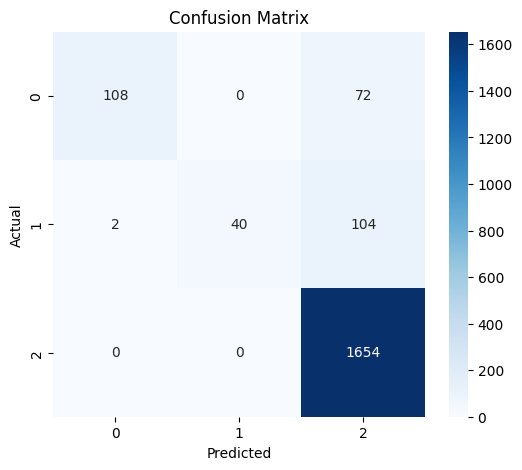

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_tree_100, cv, X, y)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

####**Jumlah Tree = 200**

In [ ]:
model_tree_200 = RandomForestClassifier(n_estimators=200,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_tree_200 = cross_val_score(model_tree_200, X, y, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_tree_200)
print('Rata-rata akurasi :', scores_tree_200.mean())

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.33      0.50        15
           2       0.91      1.00      0.95       167

    accuracy                           0.92       198
   macro avg       0.97      0.65      0.74       198
weighted avg       0.93      0.92      0.90       198

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.12      0.21        17
           2       0.89      1.00      0.94       165

    accuracy                           0.89       198
   macro avg       0.96      0.58      0.64       198
weighted avg       0.91      0.89      0.86       198

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       1.00      0.22      0.36        18
           2       0.89      1.00      0.94       161

    accuracy        

**Confusion Matrix**

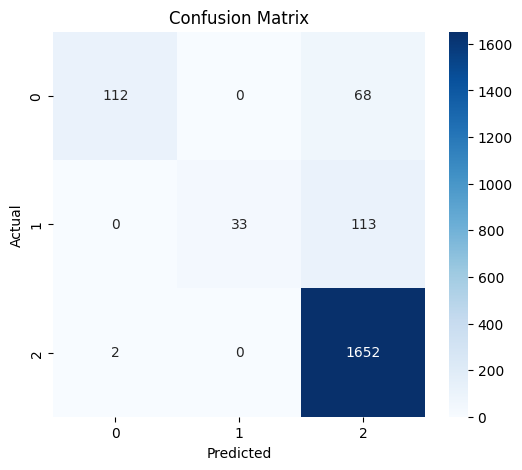

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_tree_200, cv, X, y)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

####**Jumlah Tree = 300**

In [ ]:
model_tree_300 = RandomForestClassifier(n_estimators=300,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_tree_300 = cross_val_score(model_tree_300, X, y, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_tree_300)
print('Rata-rata akurasi :', scores_tree_300.mean())

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.40      0.57        15
           2       0.92      1.00      0.96       167

    accuracy                           0.92       198
   macro avg       0.97      0.67      0.77       198
weighted avg       0.93      0.92      0.91       198

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.12      0.21        17
           2       0.89      1.00      0.94       165

    accuracy                           0.89       198
   macro avg       0.96      0.58      0.64       198
weighted avg       0.91      0.89      0.86       198

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       1.00      0.17      0.29        18
           2       0.88      1.00      0.94       161

    accuracy        

**Confusion Matrix**

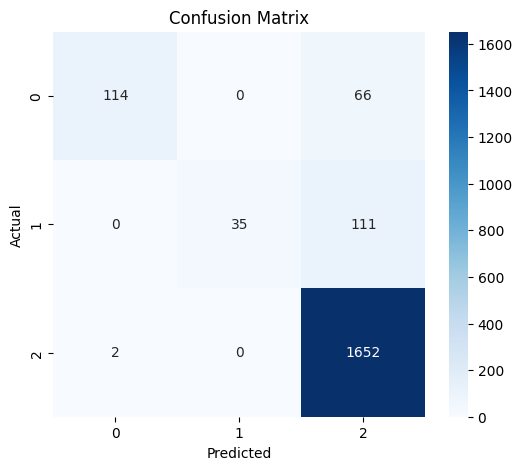

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_tree_300, cv, X, y)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

###**Pengujian Kedalaman Tree**

####**Kedalaman Tree = 30**

In [ ]:
model_depth_30 = RandomForestClassifier(n_estimators=300,
                                        max_depth=30,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_depth_30 = cross_val_score(model_depth_30, X, y, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_depth_30)
print('Rata-rata akurasi :', scores_depth_30.mean())

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        16
           1       0.00      0.00      0.00        15
           2       0.86      1.00      0.93       167

    accuracy                           0.86       198
   macro avg       0.62      0.42      0.44       198
weighted avg       0.81      0.86      0.81       198

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.00      0.00      0.00        17
           2       0.84      1.00      0.91       165

    accuracy                           0.84       198
   macro avg       0.61      0.38      0.38       198
weighted avg       0.78      0.84      0.78       198

              precision    recall  f1-score   support

           0       1.00      0.42      0.59        19
           1       0.00      0.00      0.00        18
           2       0.85      1.00      0.92       161

    accuracy        

**Confusion Matrix**

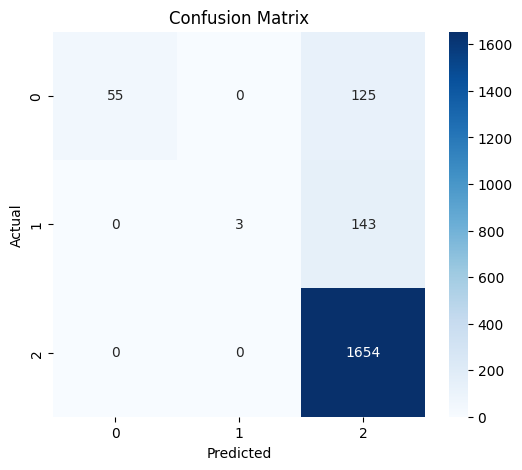

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_depth_30, cv, X, y)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

####**Kedalaman Tree = 40**

In [ ]:
model_depth_40 = RandomForestClassifier(n_estimators=300,
                                        max_depth=40,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_depth_40 = cross_val_score(model_depth_40, X, y, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_depth_40)
print('Rata-rata akurasi :', scores_depth_40.mean())

              precision    recall  f1-score   support

           0       1.00      0.56      0.72        16
           1       0.00      0.00      0.00        15
           2       0.88      1.00      0.94       167

    accuracy                           0.89       198
   macro avg       0.63      0.52      0.55       198
weighted avg       0.83      0.89      0.85       198

              precision    recall  f1-score   support

           0       1.00      0.19      0.32        16
           1       0.00      0.00      0.00        17
           2       0.85      1.00      0.92       165

    accuracy                           0.85       198
   macro avg       0.62      0.40      0.41       198
weighted avg       0.79      0.85      0.79       198

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        19
           1       1.00      0.06      0.11        18
           2       0.86      1.00      0.92       161

    accuracy        

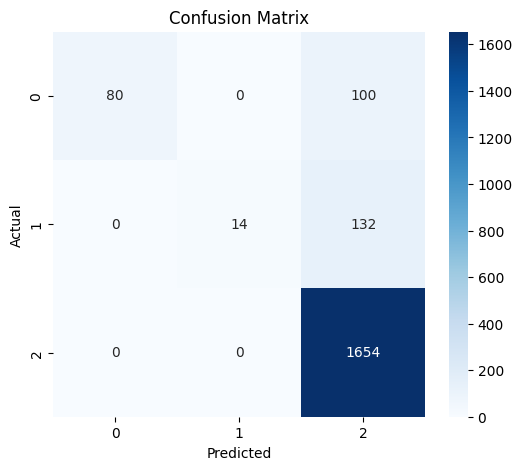

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_depth_40, cv, X, y)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

####**Kedalaman Tree = 50**

In [ ]:
model_depth_50 = RandomForestClassifier(n_estimators=300,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_depth_50 = cross_val_score(model_depth_50, X, y, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_depth_50)
print('Rata-rata akurasi :', scores_depth_50.mean())

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.40      0.57        15
           2       0.92      1.00      0.96       167

    accuracy                           0.92       198
   macro avg       0.97      0.67      0.77       198
weighted avg       0.93      0.92      0.91       198

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       1.00      0.12      0.21        17
           2       0.89      1.00      0.94       165

    accuracy                           0.89       198
   macro avg       0.96      0.58      0.64       198
weighted avg       0.91      0.89      0.86       198

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       1.00      0.17      0.29        18
           2       0.88      1.00      0.94       161

    accuracy        

**Confusion Matrix**

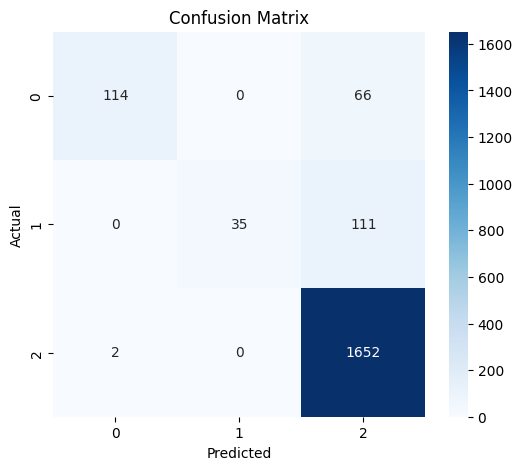

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_depth_50, cv, X, y)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

###**Pengujian Jumlah Data**

####**Jumlah Data = 400**

In [ ]:
data_400 = df_clean.sample(n=400, random_state=0)
data_400.reset_index(inplace=True)
data_400 = data_400.drop(columns=['index'])
data_400.head()

,Review,Label,review
0,"[bagus, sayang, mabuk, laut]",2,bagus sayang mabuk laut
1,"[bagus, mantap, mantap, recomanded]",2,bagus mantap mantap recomanded
2,"[keren, sekali, pantai]",2,keren sekali pantai
3,"[tempat, bagus, kalo, pas, siang, panas, sekal...",0,tempat bagus kalo pas siang panas sekali coba
4,"[bersih, alami, transportasi, mudah, murah, ma...",2,bersih alami transportasi mudah murah mantab


In [ ]:
# Distibusi data perkelas
data_400['Label'].value_counts()

2    347
1     31
0     22
Name: Label, dtype: int64

In [ ]:
# TF-IDF Data 400
tfidf400 = vectorizer.fit_transform(data_400['review'])
print(tfidf400)

  (0, 477)	0.4150352842539269
  (0, 504)	0.6537630749954223
  (0, 785)	0.5729533502313181
  (0, 63)	0.26844741208568296
  (1, 719)	0.6080027303979346
  (1, 526)	0.7622093257062735
  (1, 63)	0.22219276233722
  (2, 650)	0.3527165851230803
  (2, 799)	0.6409398974799394
  (2, 425)	0.6817529306116092
  (3, 175)	0.4342602847828704
  (3, 644)	0.3697172963019838
  (3, 821)	0.4213923648788181
  (3, 653)	0.410245665643405
  (3, 382)	0.3697172963019838
  (3, 904)	0.2870425315147685
  (3, 799)	0.26985877502046074
  (3, 63)	0.1922135322480931
  (4, 524)	0.5277837748970889
  (4, 576)	0.3349091709473445
  (4, 573)	0.4116616925157216
  (4, 942)	0.46972273370640527
  (4, 19)	0.4228468663213175
  (4, 115)	0.20093746830159906
  (5, 407)	0.23277848889603542
  :	:
  (393, 650)	0.10721796906215456
  (393, 63)	0.1387734601267315
  (394, 268)	0.6934218036142816
  (394, 12)	0.6934218036142816
  (394, 650)	0.19578663014780529
  (395, 957)	0.5868589239801419
  (395, 958)	0.5490938339874138
  (395, 895)	0.5015154

In [ ]:
X_400 = tfidf400
y_400 = data_400['Label']
print(X_400.shape, y_400.shape)

(400, 999) (400,)


In [ ]:
model_data_400 = RandomForestClassifier(n_estimators=300,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_data_400 = cross_val_score(model_data_400, X_400, y_400, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_data_400)
print('Rata-rata akurasi :', scores_data_400.mean())

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.50      0.67         2
           2       0.92      1.00      0.96        35

    accuracy                           0.93        40
   macro avg       0.97      0.61      0.71        40
weighted avg       0.93      0.93      0.91        40

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.88      1.00      0.93        35

    accuracy                           0.88        40
   macro avg       0.29      0.33      0.31        40
weighted avg       0.77      0.88      0.82        40

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.90      0.97      0.93        36

    accuracy                           0.88        40
   macro avg       0

**Confusion Matrix**

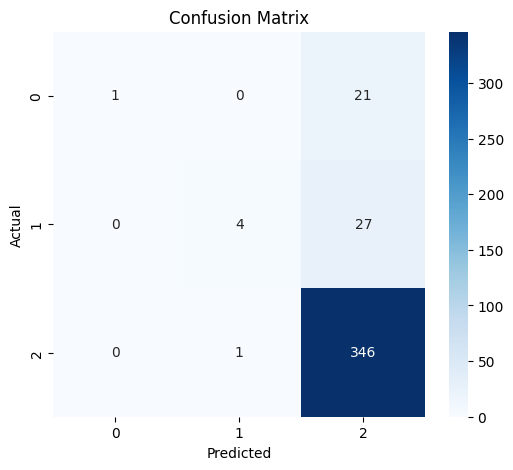

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_data_400, cv, X_400, y_400)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

####**Jumlah Data = 500**

In [ ]:
data_500 = df_clean.sample(n=500, random_state=0)
data_500.reset_index(inplace=True)
data_500 = data_500.drop(columns=['index'])
data_500.head()

,Review,Label,review
0,"[bagus, sayang, mabuk, laut]",2,bagus sayang mabuk laut
1,"[bagus, mantap, mantap, recomanded]",2,bagus mantap mantap recomanded
2,"[keren, sekali, pantai]",2,keren sekali pantai
3,"[tempat, bagus, kalo, pas, siang, panas, sekal...",0,tempat bagus kalo pas siang panas sekali coba
4,"[bersih, alami, transportasi, mudah, murah, ma...",2,bersih alami transportasi mudah murah mantab


In [ ]:
# Distibusi data perkelas
data_500['Label'].value_counts()

2    426
0     39
1     35
Name: Label, dtype: int64

In [ ]:
# TF-IDF Data 500
tfidf500 = vectorizer.fit_transform(data_500['review'])
print(tfidf500)

  (0, 558)	0.4247237802571305
  (0, 588)	0.6604835318971968
  (0, 921)	0.5573596975018849
  (0, 74)	0.26966902339220333
  (1, 850)	0.6171697276640336
  (1, 610)	0.7564324803469038
  (1, 74)	0.2165904659289828
  (2, 763)	0.3474319604659729
  (2, 938)	0.6305100732738165
  (2, 500)	0.694080744832341
  (3, 211)	0.4519626561560486
  (3, 755)	0.36043348274932274
  (3, 967)	0.427994871918565
  (3, 769)	0.39421417733394387
  (3, 449)	0.3651955470607939
  (3, 1067)	0.291849829907867
  (3, 938)	0.26890430934259696
  (3, 74)	0.1907338343362116
  (4, 608)	0.5251666276073788
  (4, 675)	0.3431638853546465
  (4, 670)	0.40616756405440874
  (4, 1107)	0.4409725589541193
  (4, 22)	0.45243485089073626
  (4, 135)	0.20569972993379568
  (5, 479)	0.23325759446567929
  :	:
  (494, 212)	0.2703084076299515
  (494, 392)	0.3740035607231547
  (494, 135)	0.16520907773773383
  (494, 763)	0.12261643475851022
  (495, 478)	0.4544882425305334
  (495, 959)	0.5658413448049672
  (495, 841)	0.40012499746617486
  (495, 900)	0

In [ ]:
X_500 = tfidf500
y_500 = data_500['Label']
print(X_500.shape, y_500.shape)

(500, 1179) (500,)


In [ ]:
model_data_500 = RandomForestClassifier(n_estimators=300,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_data_500 = cross_val_score(model_data_500, X_500, y_500, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_data_500)
print('Rata-rata akurasi :', scores_data_500.mean())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.92      1.00      0.96        46

    accuracy                           0.92        50
   macro avg       0.31      0.33      0.32        50
weighted avg       0.85      0.92      0.88        50

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.60      0.75         5
           2       0.91      1.00      0.95        42

    accuracy                           0.92        50
   macro avg       0.97      0.64      0.73        50
weighted avg       0.93      0.92      0.91        50

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       1.00      0.50      0.67         2
           2       0.87      1.00      0.93        41

    accuracy        

**Confusion Matrix**

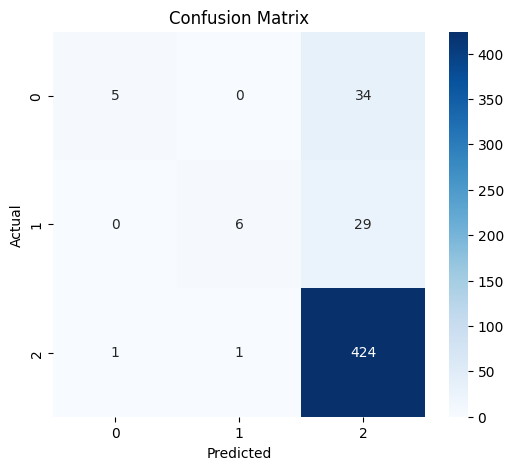

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_data_500, cv, X_500, y_500)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

####**Jumlah Data = 550**

In [ ]:
data_550 = df_clean.sample(n=550, random_state=0)
data_550.reset_index(inplace=True)
data_550 = data_550.drop(columns=['index'])
data_550.head()

,Review,Label,review
0,"[bagus, sayang, mabuk, laut]",2,bagus sayang mabuk laut
1,"[bagus, mantap, mantap, recomanded]",2,bagus mantap mantap recomanded
2,"[keren, sekali, pantai]",2,keren sekali pantai
3,"[tempat, bagus, kalo, pas, siang, panas, sekal...",0,tempat bagus kalo pas siang panas sekali coba
4,"[bersih, alami, transportasi, mudah, murah, ma...",2,bersih alami transportasi mudah murah mantab


In [ ]:
# Distibusi data perkelas
data_550['Label'].value_counts()

2    465
0     45
1     40
Name: Label, dtype: int64

In [ ]:
# TF-IDF Data 500
tfidf550 = vectorizer.fit_transform(data_550['review'])
print(tfidf550)

  (0, 576)	0.41976650143752386
  (0, 608)	0.6568592665315847
  (0, 951)	0.5648521629488364
  (0, 74)	0.27069174766606957
  (1, 880)	0.6244868219001707
  (1, 630)	0.7509651208145572
  (1, 74)	0.21463363341518066
  (2, 788)	0.3426030407636212
  (2, 968)	0.6269228498279646
  (2, 515)	0.699707722426374
  (3, 217)	0.4500357432393137
  (3, 780)	0.3662883804999637
  (3, 998)	0.420121147877305
  (3, 794)	0.4048297020105621
  (3, 464)	0.357894305681866
  (3, 1102)	0.2885601530268815
  (3, 968)	0.2741469429425159
  (3, 74)	0.190787691728052
  (4, 628)	0.5311685290915865
  (4, 697)	0.3372156019372805
  (4, 692)	0.41265228637204715
  (4, 1143)	0.4372466288731682
  (4, 22)	0.4473160652306958
  (4, 138)	0.20636725852290155
  (5, 494)	0.2339345610910391
  :	:
  (545, 200)	0.12982425560147204
  (545, 471)	0.4460448813274569
  (545, 350)	0.10245057708169757
  (545, 930)	0.22548056993542592
  (545, 996)	0.12982425560147204
  (545, 422)	0.11033679920084513
  (545, 138)	0.06377540828332562
  (545, 464)	0.

In [ ]:
X_550 = tfidf550
y_550 = data_550['Label']
print(X_550.shape, y_550.shape)

(550, 1217) (550,)


In [ ]:
model_data_550 = RandomForestClassifier(n_estimators=300,
                                        max_depth=50,
                                        random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_data_550 = cross_val_score(model_data_550, X_550, y_550, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_data_550)
print('Rata-rata akurasi :', scores_data_550.mean())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.84      1.00      0.91        46

    accuracy                           0.84        55
   macro avg       0.28      0.33      0.30        55
weighted avg       0.70      0.84      0.76        55

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.00      0.00      0.00         2
           2       0.83      1.00      0.91        44

    accuracy                           0.84        55
   macro avg       0.61      0.41      0.42        55
weighted avg       0.83      0.84      0.79        55

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.33      0.50         3
           2       0.91      1.00      0.95        49

    accuracy        

**Confusion Matrix**

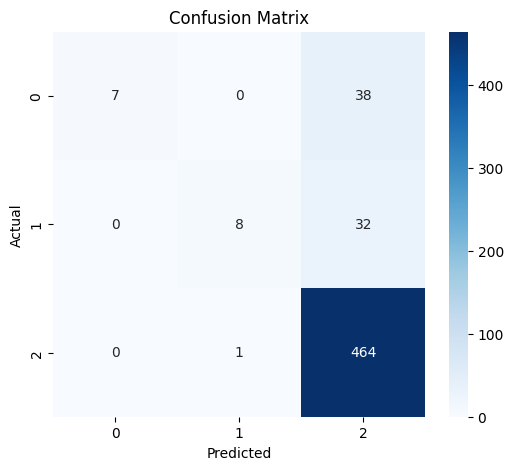

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_data_550, cv, X_550, y_550)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])

###**Pengujian Algoritma Random Forest**

Gabungan parameter terbaik dari pengujian diatas:


*   Jumlah Tree = 300
*   Kedalaman Tree = 50
*   Jumlah Data = 550



In [ ]:
model_final = RandomForestClassifier(n_estimators=300,
                               max_depth=50,
                               random_state=0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores_final = cross_val_score(model_final, X_550, y_550, cv=cv,
                                 scoring=make_scorer(classification_report_with_accuracy_score))

print('Keseluruhan akurasi :\n', scores_final)
print('Rata-rata akurasi :', scores_final.mean())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.84      1.00      0.91        46

    accuracy                           0.84        55
   macro avg       0.28      0.33      0.30        55
weighted avg       0.70      0.84      0.76        55

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.00      0.00      0.00         2
           2       0.83      1.00      0.91        44

    accuracy                           0.84        55
   macro avg       0.61      0.41      0.42        55
weighted avg       0.83      0.84      0.79        55

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.33      0.50         3
           2       0.91      1.00      0.95        49

    accuracy        

**Confusion Matrix**

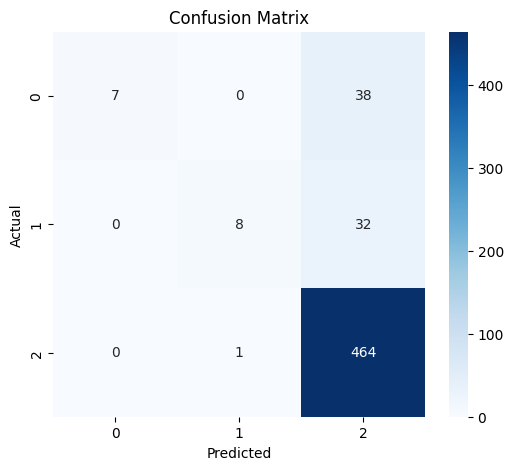

In [ ]:
actual_classes, predicted_classes, _ = cross_val_predict(model_final, cv, X_550, y_550)
plot_confusion_matrix(actual_classes, predicted_classes, [0,1,2])